In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class Network(nn.Module):
    def __init__(self, output_size, activation = nn.Identity()):
        super(Network, self).__init__()
        # in this case, the number of channels is 10 because we retrieve last 10 snapshots
        self.conv1 = nn.Conv1d(in_channels=10, out_channels=10, kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv1d(in_channels=10, out_channels=10, kernel_size=2, stride=2, padding=0)
        self.conv3 = nn.Conv1d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=0)
        self.lstm = nn.LSTM(input_size=1, hidden_size=1, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(11, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_size)
        self.activation = activation
        

    def forward(self, x1, x2):
        x1 = self.conv1(x1) 
        x1 = F.relu(x1)
        x1 = self.conv2(x1)
        x1 = F.relu(x1)
        x1 = self.conv3(x1)
        x1 = F.relu(x1)
        x1 = x1.reshape(10, 1, 1)
        x1, _ = self.lstm(x1)
        x1 = x1.reshape(10, )
        x1 = torch.cat((x1, x2), dim = 0)
        x1 = self.fc1(x1)
        x1 = F.relu(x1)
        x1 = self.fc2(x1)
        x1 = F.relu(x1)
        x1 = self.fc3(x1)
        x1 = self.activation(x1)
        return x1
    

In [2]:
torch.__version__

'2.0.1+cu118'

In [3]:
df = pd.read_csv('cleaned_dataset.csv')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_data = df[df['trading_day'] == 25]
train_data = train_data.drop(['trading_day'], axis=1)
train_data = train_data[['AskPrice1', 'AskVolume1', 'BidPrice1', 'BidVolume1', 'AskPrice2', 'AskVolume2', 'BidPrice2', 'BidVolume2', 'AskPrice3', 'AskVolume3', 'BidPrice3', 'BidVolume3']]
train_data = train_data.iloc[:4000, :]
print(train_data.head())
train_data = train_data.to_numpy()
train_data = torch.from_numpy(train_data)
train_data = train_data.float()
train_data = train_data.to(device)

         AskPrice1  AskVolume1  BidPrice1  BidVolume1  AskPrice2  AskVolume2  \
1887801      769.0          40      768.5         116      769.5         293   
1887802      768.5           5      768.0         293      769.0         132   
1887803      768.5           4      768.0         303      769.0         311   
1887804      769.0         185      768.5          24      769.5         409   
1887805      769.0         163      768.5          23      769.5         417   

         BidPrice2  BidVolume2  AskPrice3  AskVolume3  BidPrice3  BidVolume3  
1887801      768.0         293      770.0         603      767.5         154  
1887802      767.5         184      769.5         338      767.0         323  
1887803      767.5         305      769.5         396      767.0         364  
1887804      768.0         357      770.0         754      767.5         317  
1887805      768.0         458      770.0         765      767.5         319  


Therefore, I think it makes sense that to consider snapshots for the last 10 seconds as an input, and start from there. For each snapshot, we only use the first three bid-ask price level, which means 12 features

In [4]:
# write a function to get a path from the policy network
def get_path(policy_network, train_dataset):
    holding_positions = [0]
    pos_changes = []
    rewards = []
    states1 = []
    states2 = [] 
    action_dist_set = []
    action_set = []
    for i in range(9, len(train_dataset)):

        # bid_ask information of past 10 snapshots
        bid_ask = train_dataset[i - 9:i + 1, :]
        bid_ask = bid_ask.unsqueeze(0)
        old_hold = holding_positions[-1]
        hold = torch.tensor([old_hold]).float().to(device)
        states1.append(bid_ask)
        states2.append(hold)
        # get the action from the policy network, which is a probability distribution
        action_dist = policy_network(bid_ask, hold)
        action_dist_set.append(action_dist)
        # sample an action from the probability distribution
        action = torch.multinomial(action_dist, 1).item() - 1
        action_set.append(action + 1)
        
        # decide the position change based on the action and current holding position
        if old_hold == 0:
            # make the action to be integer
            a = int(action)
            holding_positions.append(a)
        if old_hold == 1:
            holding_positions.append(min(action + old_hold, old_hold))
        if old_hold == -1:
            holding_positions.append(max(action + old_hold, old_hold))
           
        # compute the reward (cash change) 
        new_hold = holding_positions[-1]
        position_change = new_hold - old_hold
        pos_changes.append(position_change)
    
        reward = 0
        if position_change == 0:
            reward = 0
        if position_change == 1:
            reward = - train_dataset[i][2] 
        if position_change == -1:
            reward = train_dataset[i][0] 

        rewards.append(reward)
    
    # at the end, the agent needs to liquid all positions
    if holding_positions[-1] == 1:
        rewards.append(train_dataset[-1][2])
    elif holding_positions[-1] == -1:
        rewards.append(-train_dataset[-1][0])
    else:
        rewards.append(0)

    # convert the list of rewards to a tensor
    rewards = torch.tensor(rewards).float().to(device)
    # convert the list of states to a tensor
    states1 = torch.stack(states1).to(device)
    states2 = torch.stack(states2).to(device)
    action_dist_set = torch.stack(action_dist_set).to(device)
    return states1, states2, rewards, action_dist_set, action_set


        
# train the value network using the TD(0) algorithm
def train_value_network(value_network, policy_network, train_dataset, value_optimizer, gamma = 0.99, epochs = 20):
    # define the loss function
    loss = 0
    losses = []
    # loop over the epochs
    for epoch in range(epochs):
        # get the path from the policy network
        # only use one trajectory each epoch
        states1, states2, rewards, action_dist_set, action_set = get_path(policy_network, train_dataset)
        # get the value estimate from the value network
        value_estimate = []
        for i in range(len(states1)):
            value_estimate.append(value_network(states1[i], states2[i]))
        value_estimate = torch.stack(value_estimate).squeeze(1)
        new_value_estimate = torch.cat((value_estimate, torch.tensor([0]).to(device)))
        # compute the TD(0) error
        loss = (rewards[:-1] + gamma * new_value_estimate[1:] - new_value_estimate[:-1]).pow(2).mean()
        # zero the gradient
        value_optimizer.zero_grad()
        # compute the gradient
        loss.backward()
        # update the weights
        value_optimizer.step()
        # print the loss
        losses.append(loss.item())
        if (epoch - 4) % 5 == 0:
            print('value epoch: {}, value loss: {:.5f}'.format(epoch + 1, loss.item()))

    plt.figure(figsize = (10, 5))
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.show()
    return None


# the following define a function that compute advantage estimation for a trajectory
def advantage_estimate(states1, states2, rewards, value_network, gamma):
    value_estimate = []
    for i in range(len(states1)):
        value_estimate.append(value_network(states1[i], states2[i]))
    value_estimate = torch.stack(value_estimate).squeeze(1)
    new_value_estimate = torch.cat((value_estimate, torch.tensor([0]).to(device)))
    advantages = rewards[:-1] + gamma * new_value_estimate[1:] - new_value_estimate[:-1]
    return advantages


        

In [5]:
# states, rewards, actions are trajetory data of old policy
# there is a new_policy_network that is updated by ppo_update()
def ppo_loss(new_policy_network, policy_network, value_network, train_dataset, batch_size, epsilon=0.2, gamma = 0.99):
    # batch size: the number of trajectories
    loss = torch.tensor(0.0, requires_grad=True).to(device)
    for _ in range(batch_size):
        states1, states2, rewards, action_dist_set, action_set = get_path(policy_network, train_dataset)
        new_action_dist_set = [policy_network(states1[i], states2[i]) for i in range(len(states1))]
        new_action_dist_set = torch.stack(new_action_dist_set).to(device)
        action_dist_set = action_dist_set.detach()
        rewards = rewards.detach()
        ratio = []
        for i in range(len(action_dist_set)):
            ratio.append(new_action_dist_set[i][action_set[i]] / action_dist_set[i][action_set[i]])
        ratio = torch.stack(ratio).to(device).detach()
        # compute the advantage of the trajectory
        advantage = advantage_estimate(states1, states2, rewards, value_network, gamma)
        advantage = advantage.detach()
        # compute the clipped ratio
        clipped_ratio = torch.clamp(ratio, 1.0 - epsilon, 1.0 + epsilon)
        # compute the surrogate loss
        policy_loss = -torch.min(ratio * advantage, clipped_ratio * advantage).mean()
        # compute the total loss
        loss = loss + policy_loss
    return loss

    
def ppo_train(new_policy_network, policy_network, value_network, optimizer, train_dataset, batch_size, epochs, epsilon=0.2, gamma = 0.99):
    # this function is used to train the new_policy_network
    losses = []
    for epoch in range(epochs):
        loss = ppo_loss(new_policy_network, policy_network, value_network, train_dataset, batch_size, epsilon, gamma)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())
        # print the loss and epoch
        if (epoch - 4) % 5 == 0:
            print("ppo epoch: ", epoch, "ppo loss: ", loss.item())

    plt.figure(figsize = (10, 5))
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.show()
    return None
    


def wealth_dist(num_traj, policy_network, dataset):
    wealths = []
    for num in range(num_traj):
        states1, states2, rewards, action_dist_set, action_set = get_path(policy_network, dataset)
        wealths.append(sum(rewards))

    return wealths


In [6]:
policy_network = Network(3, activation = nn.Softmax())
value_network = Network(1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
policy_network = nn.DataParallel(policy_network)
value_network = nn.DataParallel(value_network)
policy_network.to(device)
value_network.to(device)
policy_network = torch.compile(policy_network)
value_network = torch.compile(value_network)

policy_optimizer = optim.Adam(policy_network.parameters(), lr=0.05)
value_optimizer = optim.Adam(value_network.parameters(), lr=0.05)


[2023-08-08 03:49:01,740] torch._dynamo.convert_frame: [ERROR] WON'T CONVERT forward /tmp/ipykernel_21988/2842180769.py line 23 
due to: 
Traceback (most recent call last):
  File "/home/fangzhou/anaconda3/envs/futures/lib/python3.9/site-packages/torch/_subclasses/fake_tensor.py", line 1212, in validate
    raise Exception(
Exception: Please convert all Tensors to FakeTensors first or instantiate FakeTensorMode with 'allow_non_fake_inputs'. Found in aten.convolution.default(*(FakeTensor(FakeTensor(..., device='meta', size=(1, 10, 12)), cuda:0), tensor([[[-0.1259, -0.0830],
         [ 0.0551, -0.0882],
         [-0.0686, -0.2061],
         [ 0.1802,  0.0072],
         [-0.0830, -0.1678],
         [-0.2222,  0.0968],
         [-0.1714, -0.1401],
         [ 0.0810,  0.0361],
         [ 0.1660,  0.1368],
         [ 0.1741, -0.0516]],

        [[ 0.1357, -0.1215],
         [-0.1526, -0.0199],
         [ 0.1434, -0.1008],
         [ 0.2160, -0.0348],
         [ 0.1064, -0.1793],
         [ 0

value epoch: 5, value loss: 230142.29688
value epoch: 10, value loss: 128772.24219
value epoch: 15, value loss: 5729.76953
value epoch: 20, value loss: 16011.74121


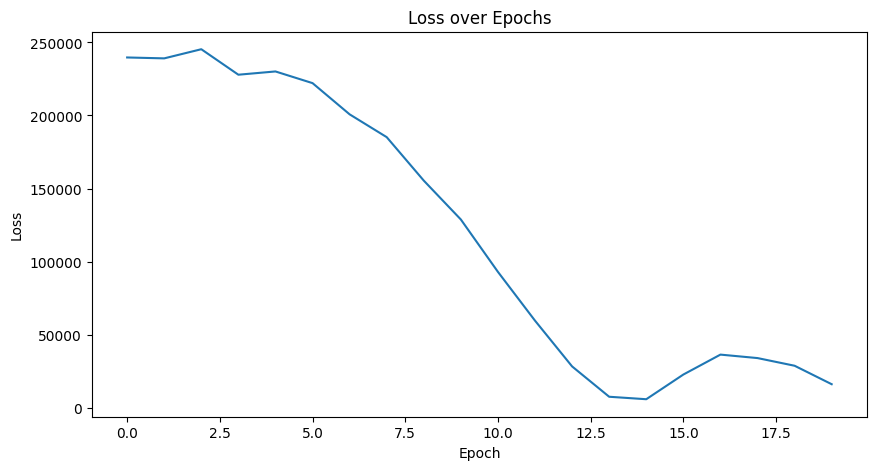

ppo epoch:  4 ppo loss:  -2.8782894611358643
ppo epoch:  9 ppo loss:  -3.1281957626342773
ppo epoch:  14 ppo loss:  -3.4059104919433594
ppo epoch:  19 ppo loss:  -3.4574458599090576


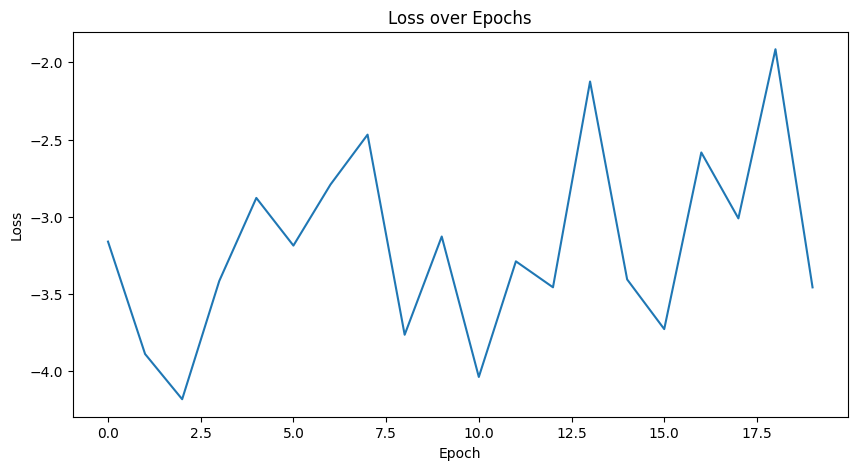

value epoch: 5, value loss: 9634.08008
value epoch: 10, value loss: 6605.67920
value epoch: 15, value loss: 7673.32617
value epoch: 20, value loss: 5235.12793


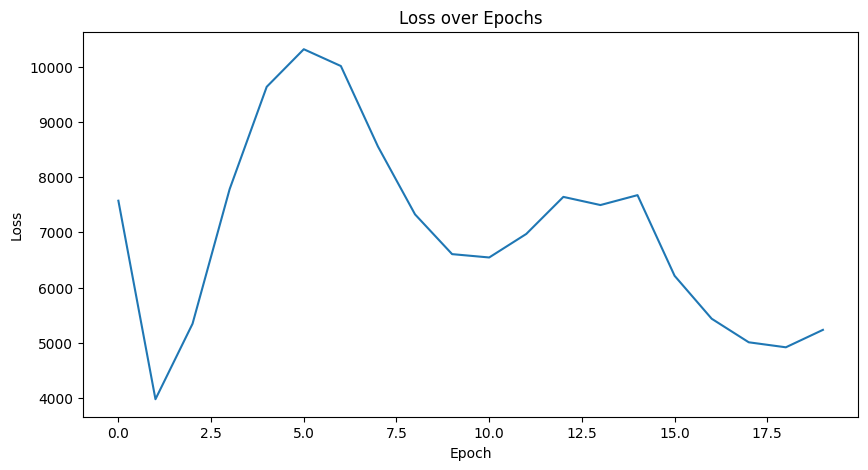

ppo epoch:  4 ppo loss:  10.314043045043945
ppo epoch:  9 ppo loss:  12.272107124328613
ppo epoch:  14 ppo loss:  10.985504150390625
ppo epoch:  19 ppo loss:  10.554003715515137


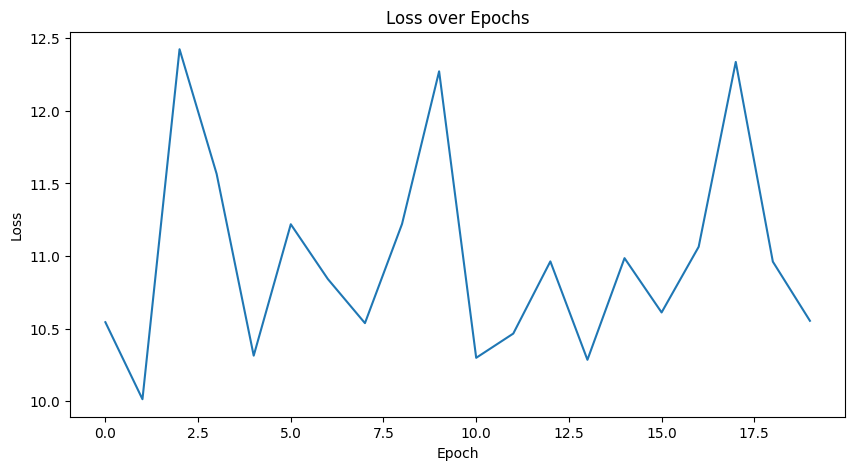

value epoch: 5, value loss: 3993.43579
value epoch: 10, value loss: 3923.47656
value epoch: 15, value loss: 3902.31641
value epoch: 20, value loss: 3816.25684


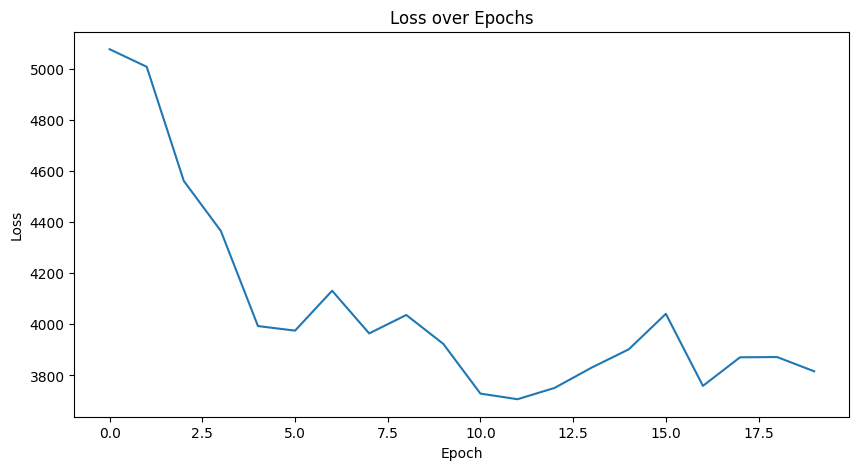

ppo epoch:  4 ppo loss:  -4.877082347869873
ppo epoch:  9 ppo loss:  -6.24075984954834
ppo epoch:  14 ppo loss:  -4.314421653747559
ppo epoch:  19 ppo loss:  -5.6770524978637695


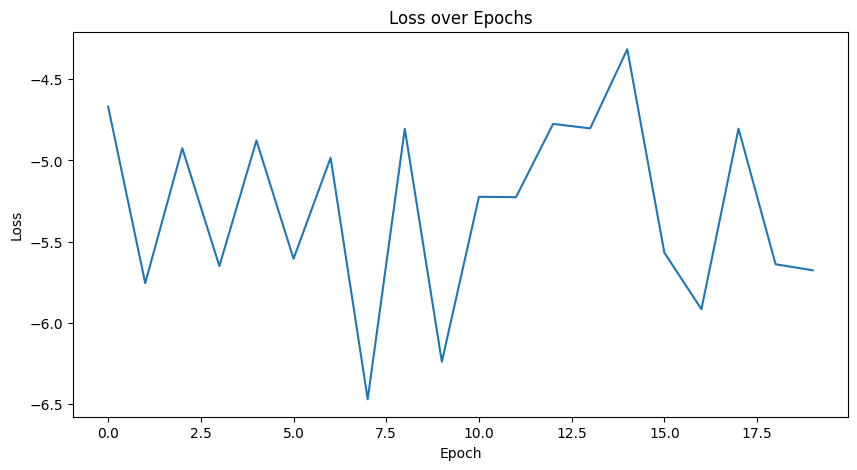

value epoch: 5, value loss: 3998.47192
value epoch: 10, value loss: 3712.39014
value epoch: 15, value loss: 3837.90625
value epoch: 20, value loss: 3772.54248


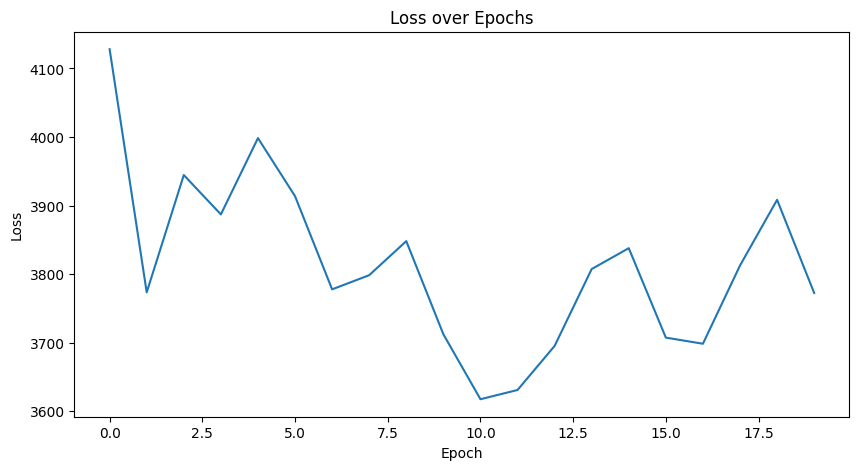

ppo epoch:  4 ppo loss:  0.1655111312866211
ppo epoch:  9 ppo loss:  0.3318617641925812
ppo epoch:  14 ppo loss:  0.3131284713745117
ppo epoch:  19 ppo loss:  0.020849376916885376


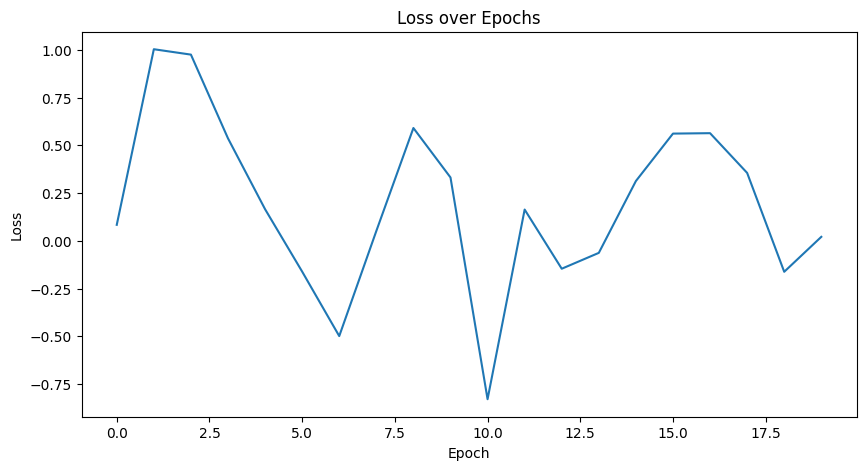

value epoch: 5, value loss: 3625.77441
value epoch: 10, value loss: 3493.00854
value epoch: 15, value loss: 3517.26855
value epoch: 20, value loss: 3752.04980


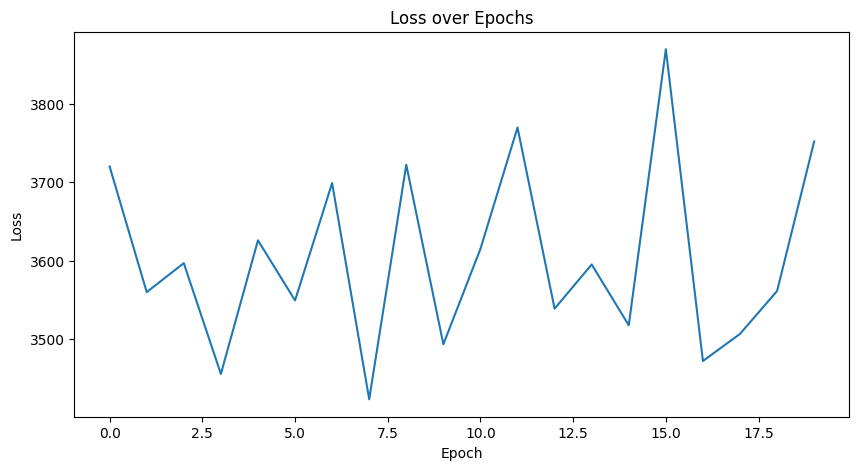

ppo epoch:  4 ppo loss:  0.3200591504573822
ppo epoch:  9 ppo loss:  0.6027247905731201
ppo epoch:  14 ppo loss:  0.43609848618507385
ppo epoch:  19 ppo loss:  -0.18001128733158112


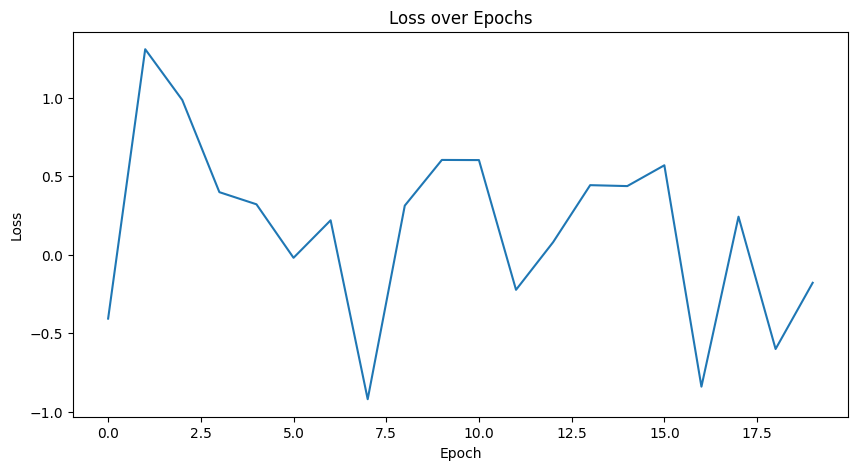

In [7]:
num_iter = 5
# num_iter this is the number of times that we improve the policy
# batch_size is the number of trajectories used of computing ppo loss
# epoch is the number of trains for ppo updates
torch._dynamo.config.suppress_errors = True
wealth_records = []
for iteration in range(num_iter):
    train_value_network(value_network, policy_network, train_data, value_optimizer, 0.9)
    new_policy_network = Network(3, activation = nn.Softmax()).to(device)
    new_policy_network = nn.DataParallel(new_policy_network)
    new_policy_optimizer = optim.Adam(new_policy_network.parameters(), lr = 0.05)
    ppo_train(new_policy_network, policy_network, value_network, new_policy_optimizer, train_data, batch_size = 5, epochs = 20, epsilon = 0.2, gamma = 0.99)
    policy_network = new_policy_network
    
    w = wealth_dist(10, policy_network, train_data)
    wealth_record = []
    for r in w:
        wealth_record.append(r.item())
    wealth_records.append(wealth_record)


In [11]:
wealth_records
torch.save(policy_network.state_dict(), 'policy_parameters.pth')
torch.save(value_network.state_dict(), 'value_parameters.pth')
wealth_numpy = np.array(wealth_records)
np.save('wealth_samples.npy', wealth_numpy)

In [12]:
print(wealth_numpy)

[[422.  447.  420.  439.  432.5 442.  440.  443.  425.5 439. ]
 [443.5 453.5 458.5 458.5 442.  461.5 453.5 460.  465.  467.5]
 [422.  410.5 401.  433.5 423.5 424.5 427.  425.  424.5 424.5]
 [432.  430.5 441.  460.5 432.  443.5 445.  443.5 461.5 439. ]
 [423.  423.5 433.  441.  445.5 441.5 449.  439.5 428.5 423.5]]
